C:\Users\34739\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


运行设备: cuda
输出目录: ./output
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\train - 5216 张影像
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\val - 16 张影像
数据集加载: E:\\HW2\\X-ray肺炎检测数据集\test - 624 张影像
训练集规模: 5216
验证集规模: 16
测试集规模: 624


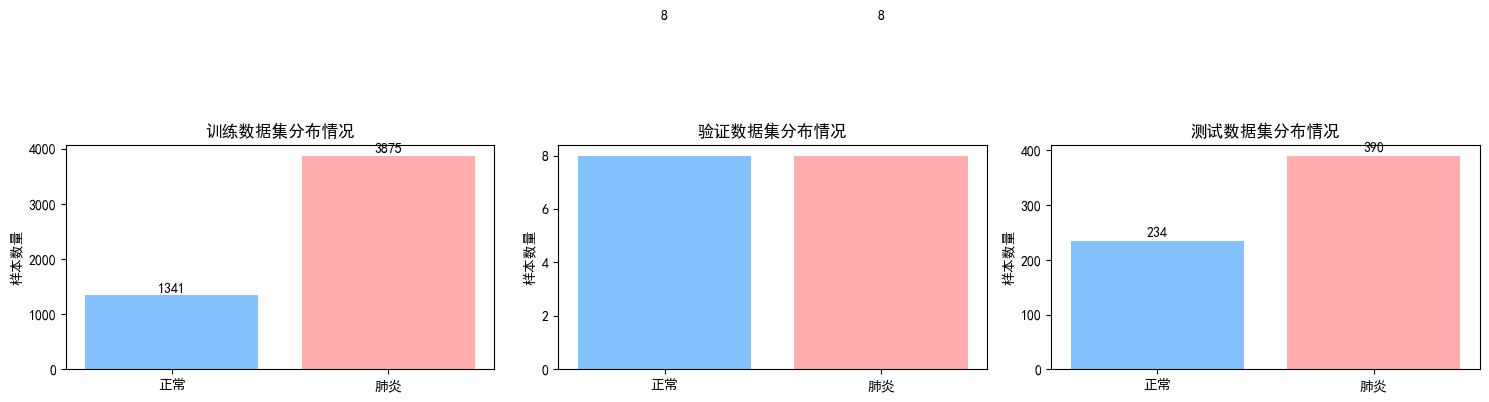

创建模型: resnet18, 类别数: 2
开始模型训练...
训练周期 1/20
--------------------------------------------------
训练损失: 0.2079 准确率: 0.9183
验证损失: 1.2730 准确率: 0.6250
验证精确率: 0.5714 召回率: 1.0000 F1: 0.7273

保存最佳模型: ./output/best_model.pth
训练周期 2/20
--------------------------------------------------
训练损失: 0.1533 准确率: 0.9377
验证损失: 0.8809 准确率: 0.5625
验证精确率: 0.5333 召回率: 1.0000 F1: 0.6957

训练周期 3/20
--------------------------------------------------
训练损失: 0.1386 准确率: 0.9484
验证损失: 0.4015 准确率: 0.8125
验证精确率: 0.7778 召回率: 0.8750 F1: 0.8235

保存最佳模型: ./output/best_model.pth
训练周期 4/20
--------------------------------------------------
训练损失: 0.1287 准确率: 0.9521
验证损失: 0.4702 准确率: 0.8125
验证精确率: 0.8571 召回率: 0.7500 F1: 0.8000

训练周期 5/20
--------------------------------------------------
训练损失: 0.1199 准确率: 0.9565
验证损失: 0.7810 准确率: 0.5000
验证精确率: 0.5000 召回率: 1.0000 F1: 0.6667

训练周期 6/20
--------------------------------------------------
训练损失: 0.1125 准确率: 0.9617
验证损失: 0.2920 准确率: 0.8125
验证精确率: 0.7273 召回率: 1.0000 F1: 0.8421

训练周期 7/20

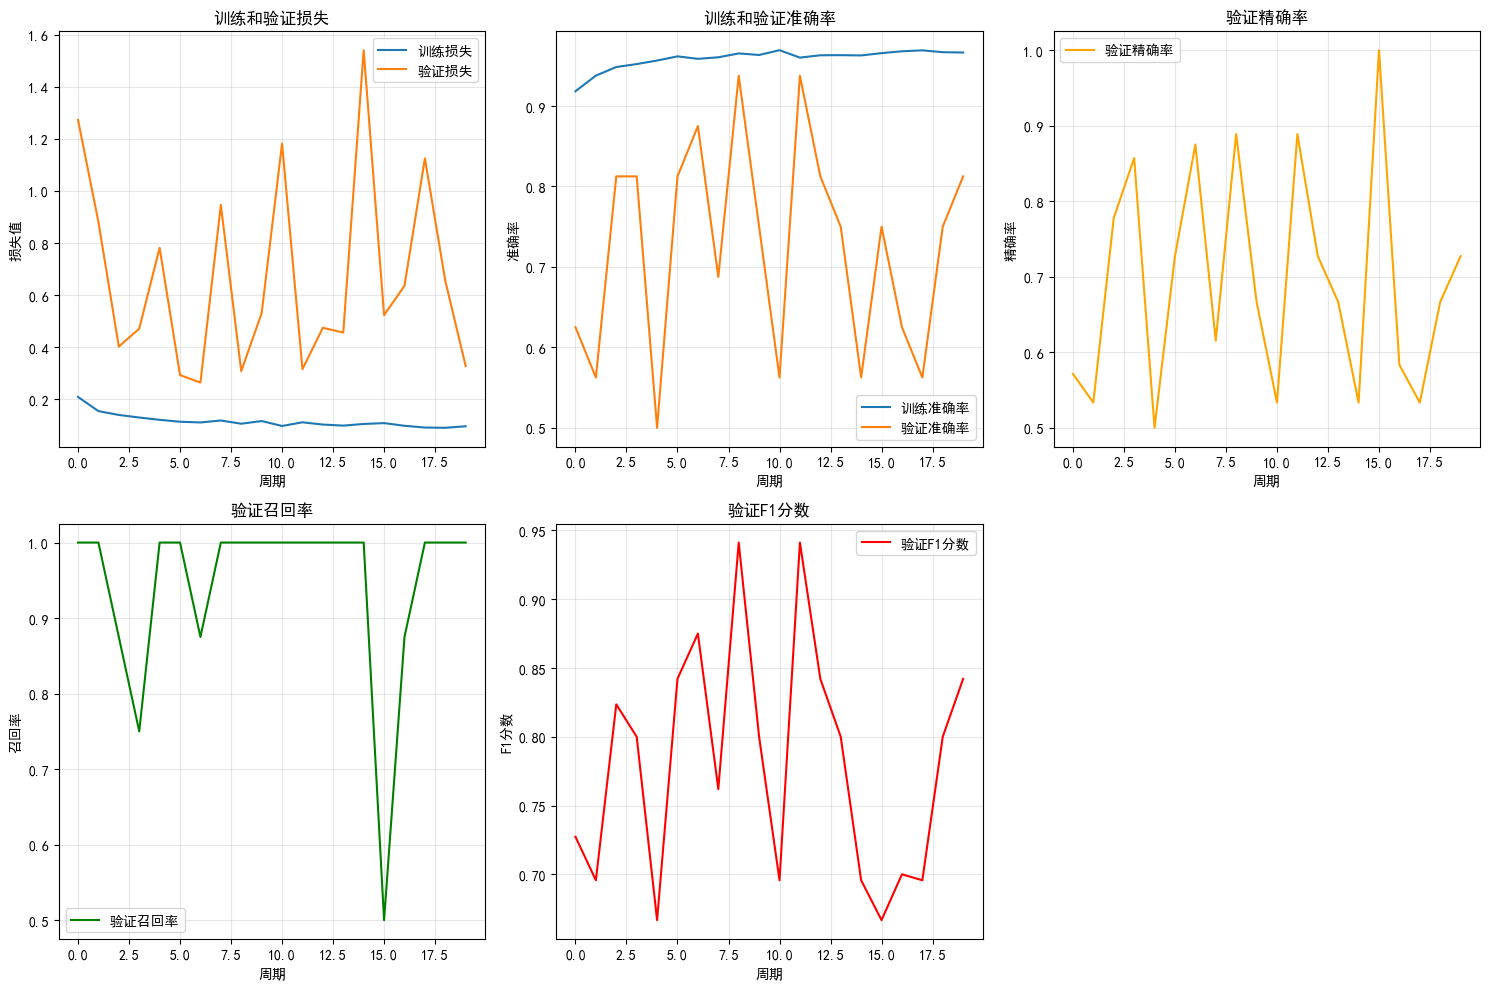

模型测试结果分析
整体准确率: 0.8462
精确率指标: 0.8050
召回率指标: 0.9949
F1综合分数: 0.8899

详细分类报告:
              precision    recall  f1-score   support

          正常       0.99      0.60      0.74       234
          肺炎       0.80      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



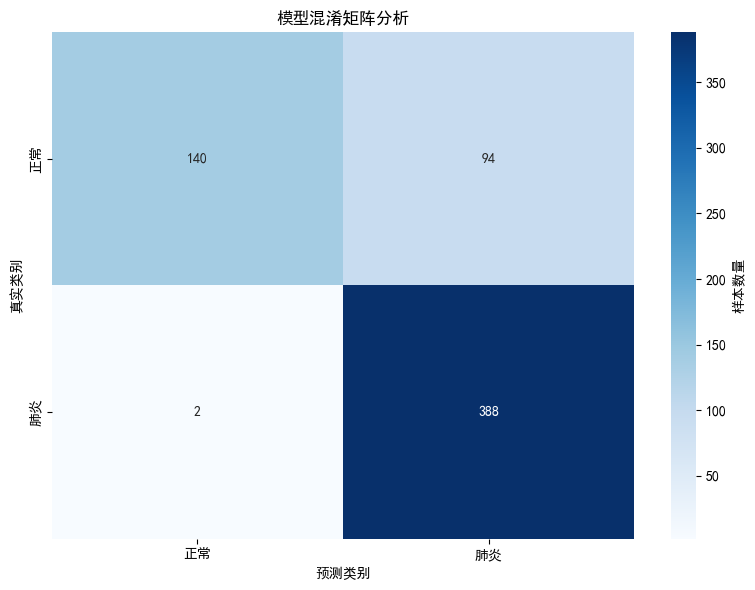

正确分类样本数: 528
错误分类样本数: 96


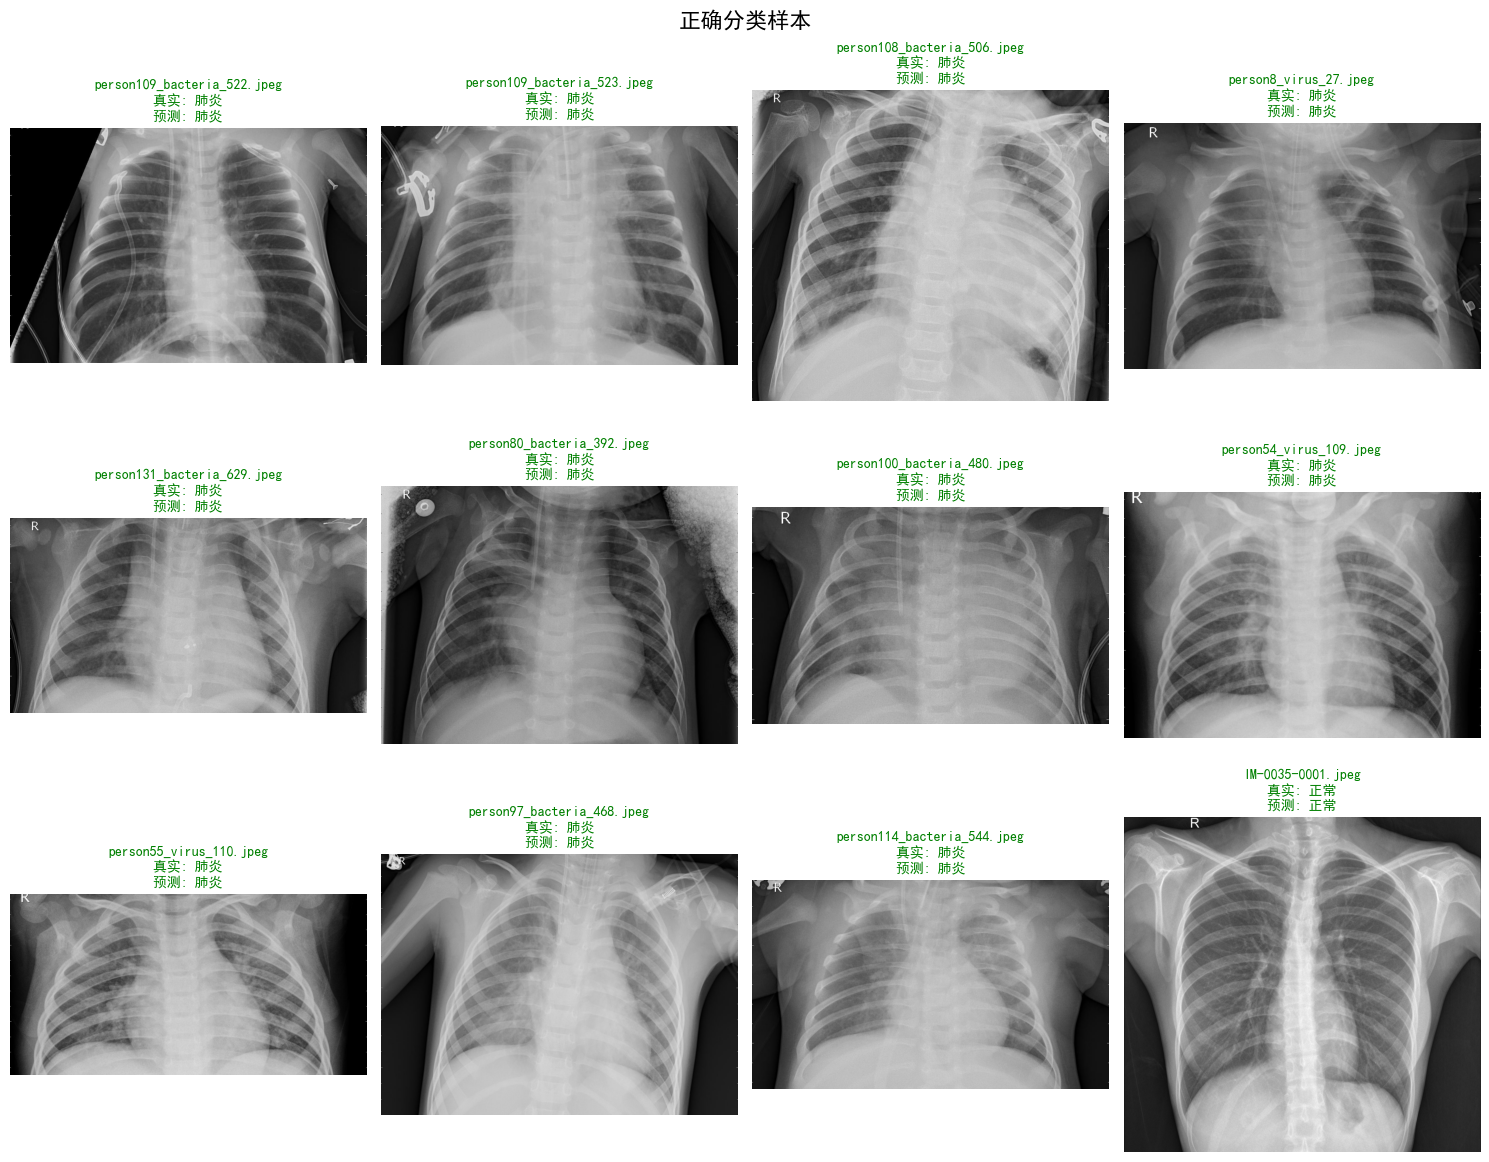

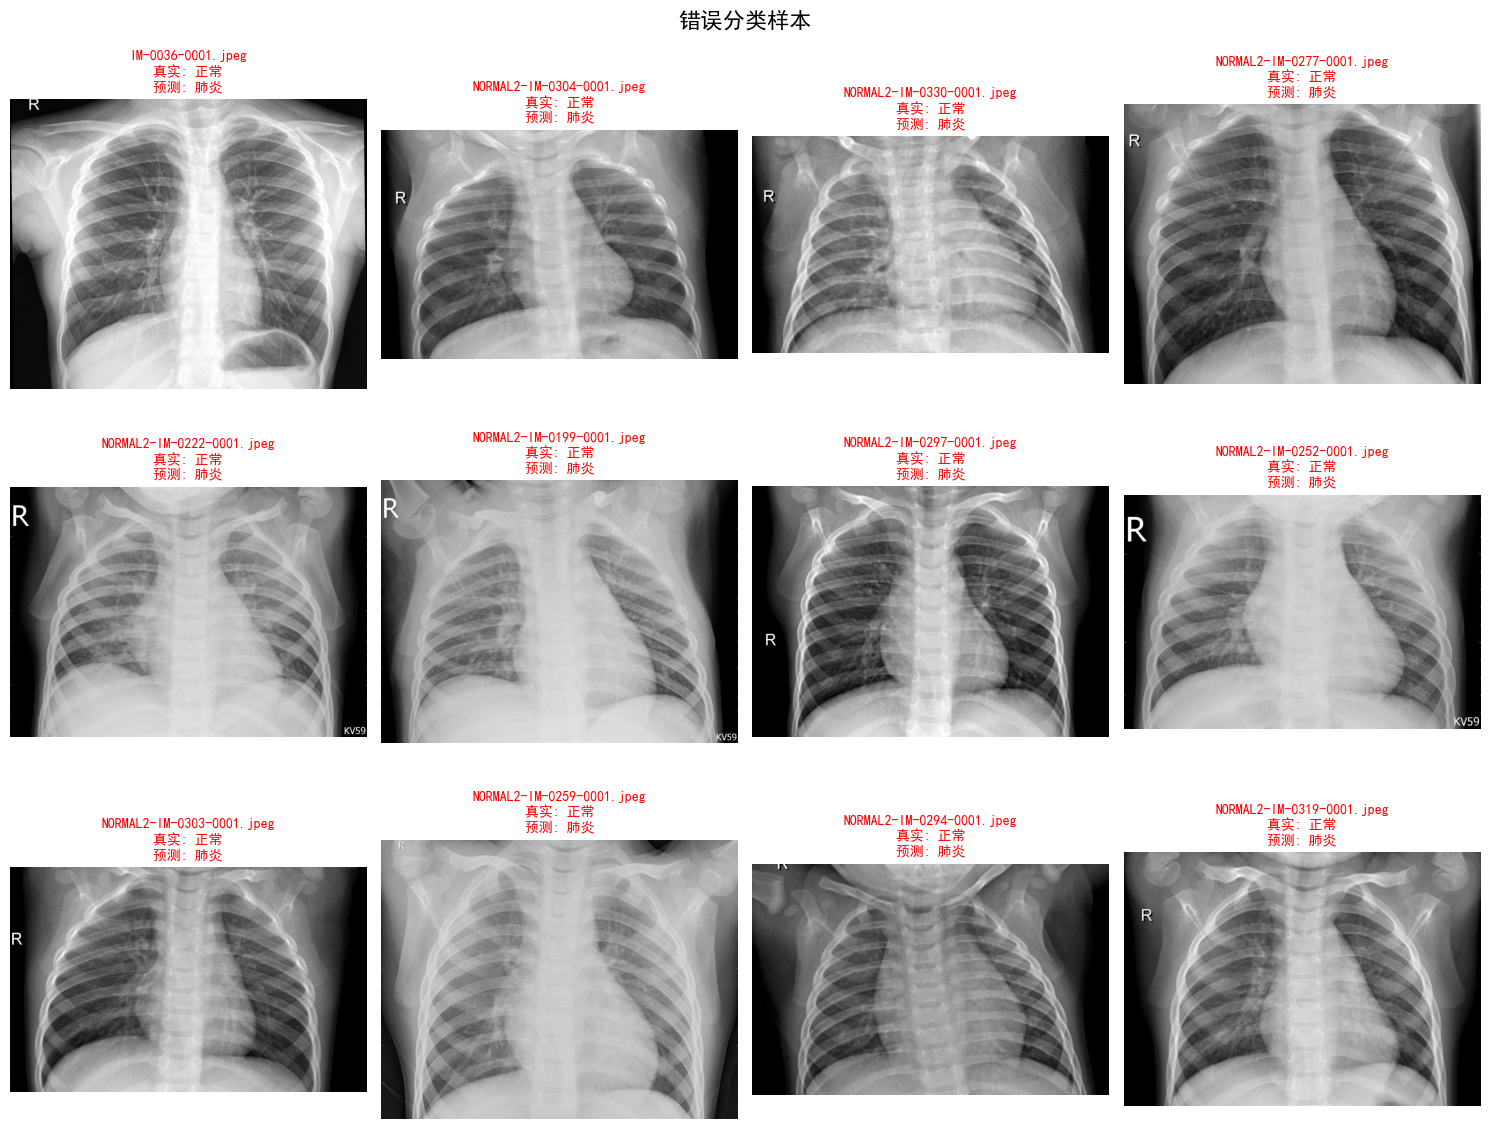


生成类激活图...
正确分类样本: 528
错误分类样本: 96


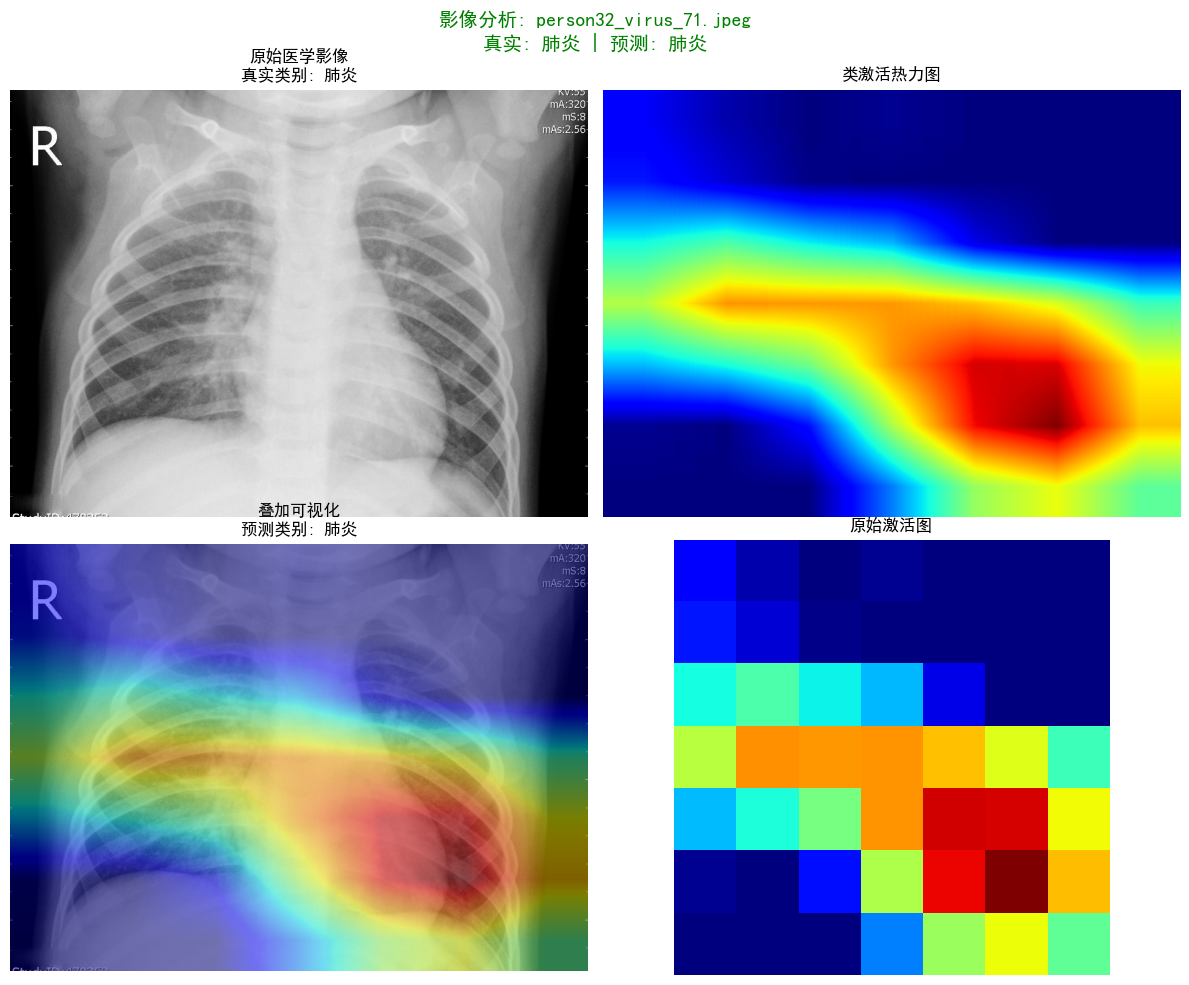


影像分析: person32_virus_71.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


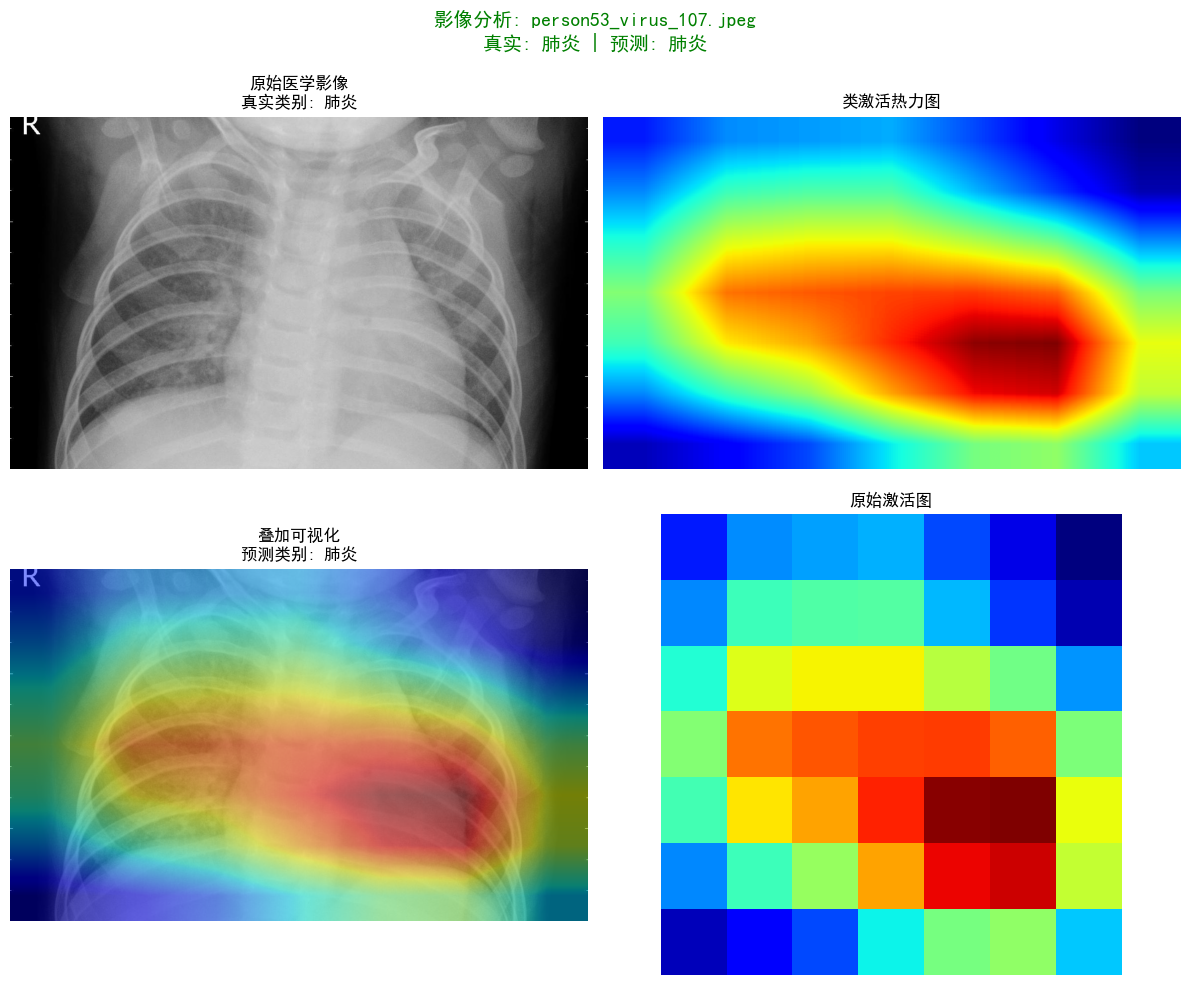


影像分析: person53_virus_107.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


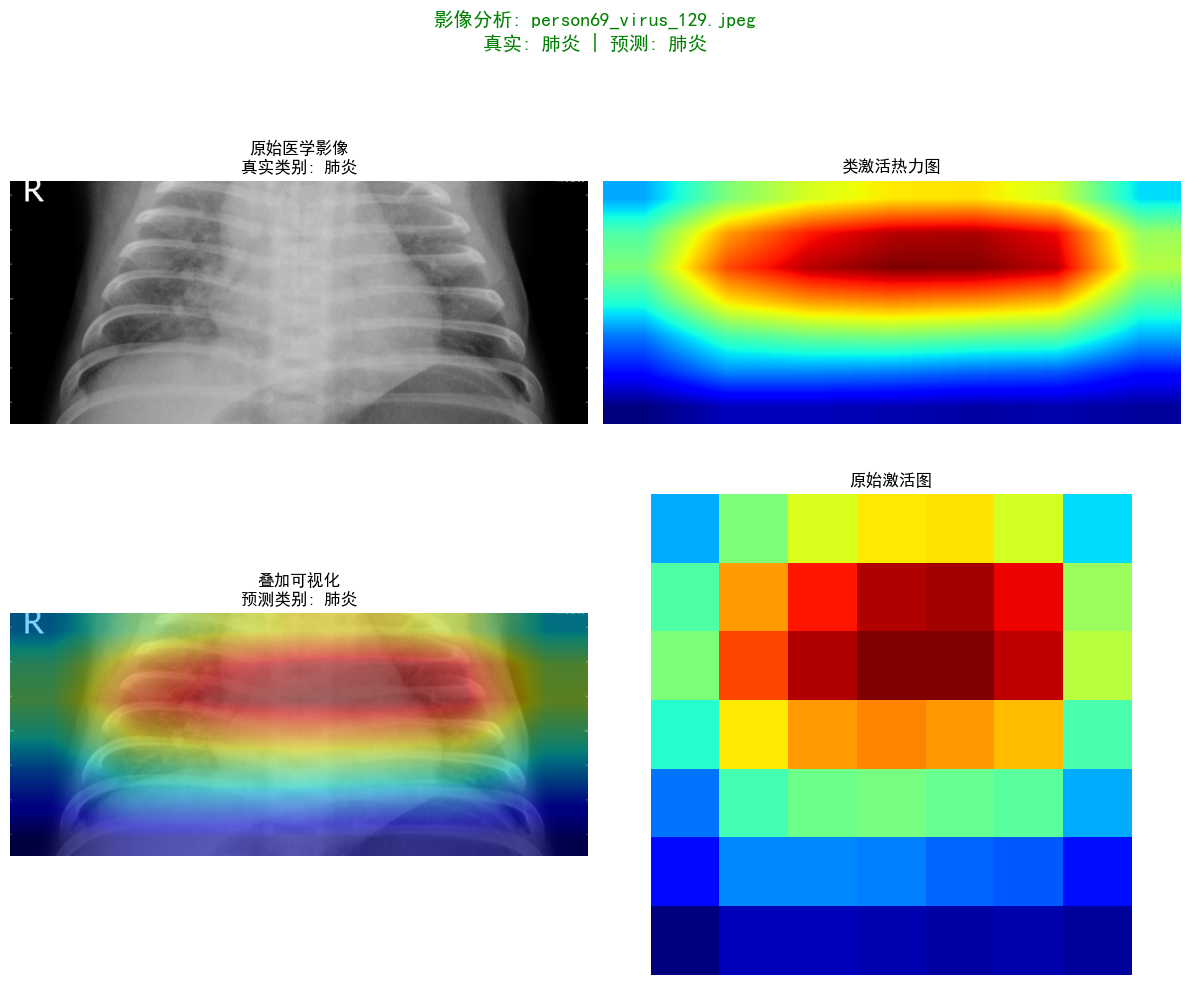


影像分析: person69_virus_129.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


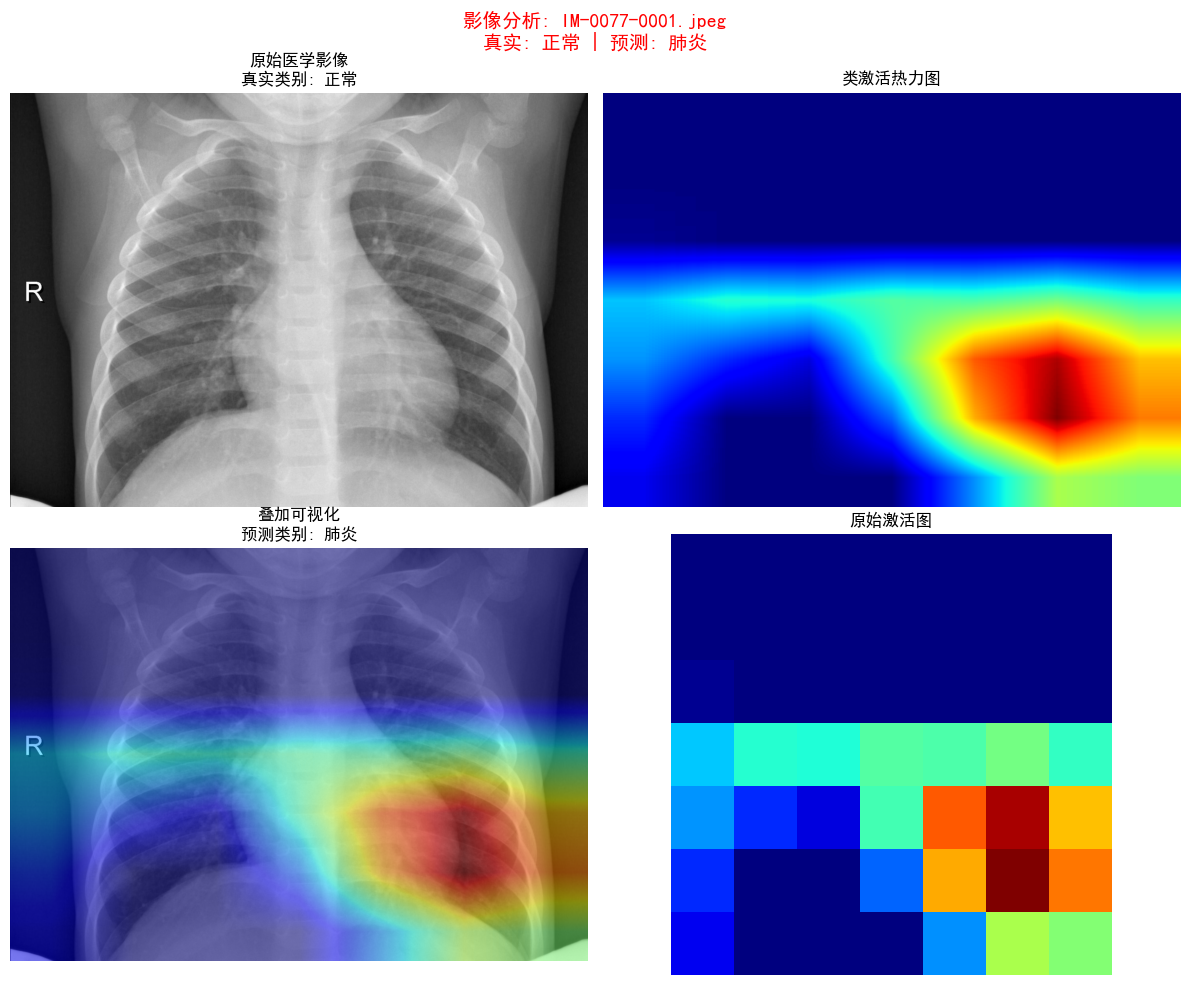


影像分析: IM-0077-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


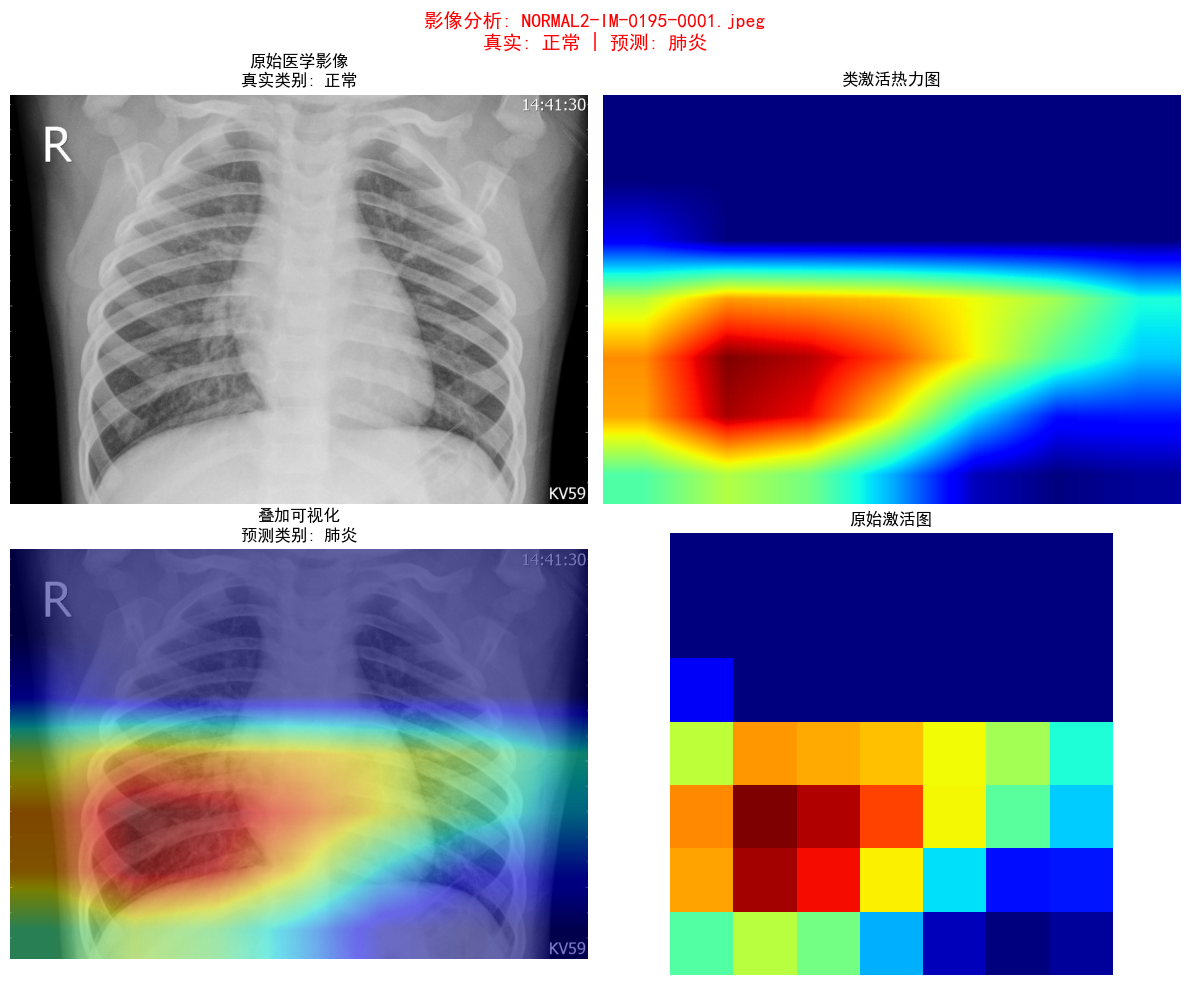


影像分析: NORMAL2-IM-0195-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------


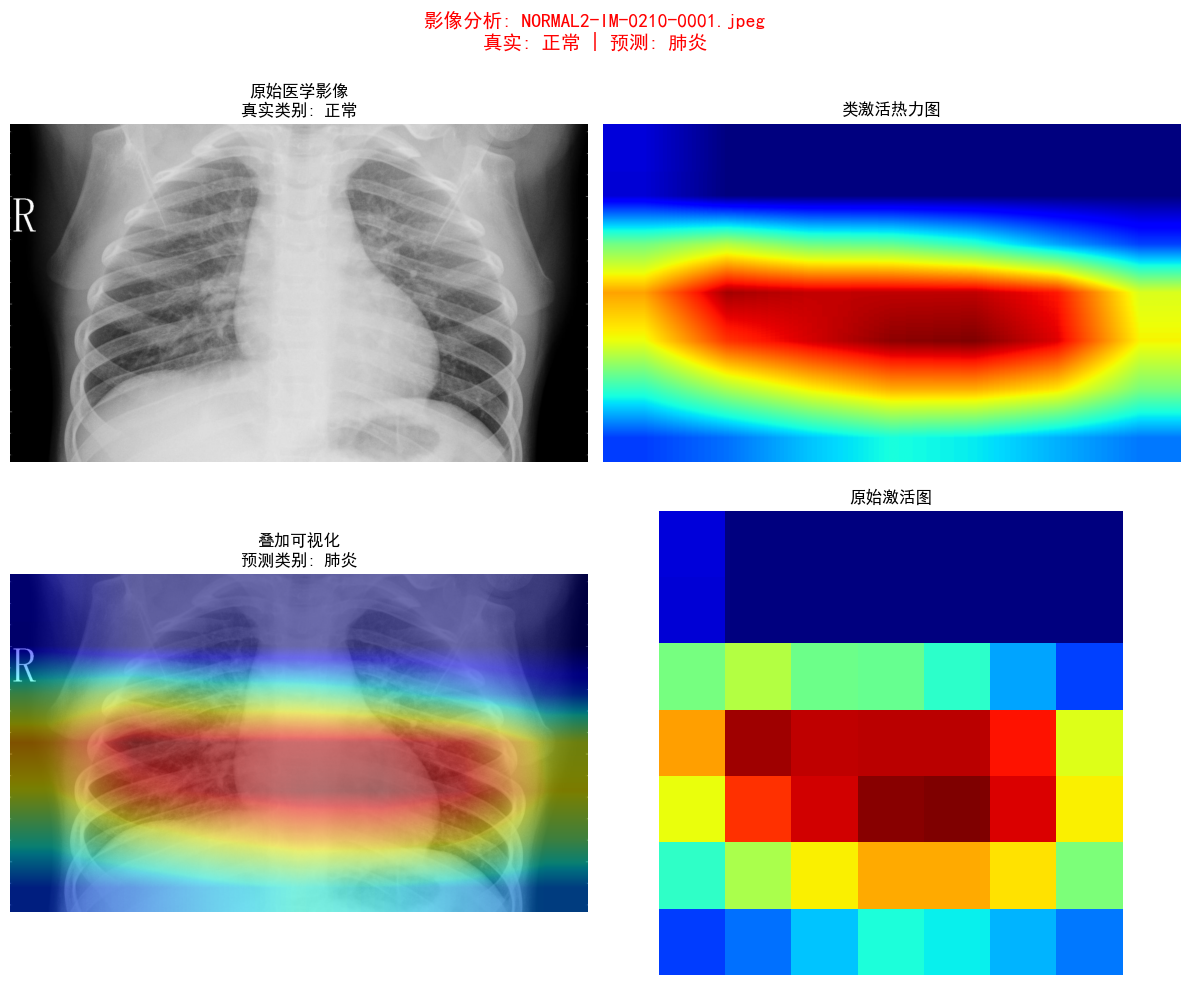


影像分析: NORMAL2-IM-0210-0001.jpeg
高激活区域比例: 0.1020
诊断分析: 检测到明显的肺炎特征区域
--------------------------------------------------

医学影像分析流程完成！
最终测试准确率: 0.8462
详细结果保存至: ./output/
操作 耗时: 1636.5625 秒


In [ ]:
"""主程序"""
import os
from config.settings import Config
from data.dataset import DataLoaderManager
from models.classifier import ModelFactory
from training.trainer import ModelTrainer
from training.evaluator import ModelEvaluator
from visualization.plots import PlotManager
from visualization.cam import CAMVisualizer

from utils import Timer 

def main():
    """主函数"""
    # 初始化配置
    Config.setup_environment()
    timer = Timer()
    timer.__enter__()

    # 检查数据路径
    if not os.path.exists(Config.DATA_ROOT):
        print(f"数据路径不存在: {Config.DATA_ROOT}")
        return
    
    try:
        # 创建数据加载器
        train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = \
            DataLoaderManager.create_data_loaders(Config.DATA_ROOT)
        
        print(f"训练集规模: {len(train_dataset)}")
        print(f"验证集规模: {len(val_dataset)}")
        print(f"测试集规模: {len(test_dataset)}")
        
        # 可视化数据分布
        PlotManager.plot_class_distribution(train_dataset, val_dataset, test_dataset)
        
        # 创建模型
        model = ModelFactory.create_model()
        
        # 训练模型
        trainer = ModelTrainer(model, train_loader, val_loader)
        trained_model, training_metrics = trainer.train()
        
        # 评估模型
        evaluator = ModelEvaluator(trained_model, test_loader)
        results = evaluator.evaluate()
        
        # 可视化结果
        confusion_mat = PlotManager.plot_confusion_matrix(
            results['true_labels'], 
            results['predictions']
        )
        
        # 可视化样本预测
        PlotManager.plot_sample_predictions(
            test_loader,
            results['predictions'],
            results['true_labels'], 
            results['image_names']
        )
        
        # 可视化CAM
        print("\n生成类激活图...")
        cam_visualizer = CAMVisualizer(trained_model)
        cam_visualizer.visualize_samples(
            test_dataset,
            results['predictions'],
            results['true_labels'],
            results['image_names']
        )
        
        # 保存结果
        evaluator.save_results(results, confusion_mat, f'{Config.OUTPUT_DIR}/evaluation_report.txt')
        
        print("\n医学影像分析流程完成！")
        print(f"最终测试准确率: {results['accuracy']:.4f}")
        print(f"详细结果保存至: {Config.OUTPUT_DIR}/")
        
    except Exception as e:
        print(f"流程执行失败: {e}")
        raise

    timer.__exit__()


if __name__ == "__main__":
    main()